<a href="https://colab.research.google.com/github/pathilink/riskified_case/blob/main/notebook/riskified_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color=#482BFF>Riskified</font> <font color=#01BFA6>Case</font>



**Tasks**

1. Rely exclusively on model scores, and set a decline threshold that will provide a 90% approval rate
2. Plot the model scores distribution
3. Assuming we aim at a proportion of 50% between the CHB cost and the total revenue (sum amount of CHBs divided by the total revenue), what would have to be the fee?


## Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


## Data

| Variable | Description |
|:--|:--|
| order_id | A unique identifier for an order |
| order_submitted_at | The date in which the order was submitted to Riskified |
| order_status | The actual status of an order (in this dataset we included only approvals and chargebacks) |
| price | Order total amount |
| digital_product | Whether the product is digital or tangible |
| customer_account_age | The interval between the date the account was created and the order was placed |
| order_source | The type of device used to place the order (web/mobile device app/phone/etc.) |
| billing_zip | The zip code filled in the billing details |
| shipping_name_length | Shipping name number of characters |

In [2]:
df = pd.read_csv('/content/drive/MyDrive/test/riskified/new_dataset.csv')
df.head()

,order_id,order_date,order_status,price,digital_product,customer_account_age,order_source,billing_zip,shipping_name_length,classification_score
0,906967102,2019-06-01,approved,213.88,False,0,web,33062,13,0.999219
1,906987974,2019-06-01,approved,50.00,True,0,mobile_app,48317,0,0.995886
2,906994260,2019-06-01,approved,100.00,True,328,web,92124,0,0.966901
3,906997653,2019-06-01,approved,25.00,True,1371,web,95448,0,0.999854
4,907408483,2019-06-01,approved,2035.76,False,139,web,61107,17,0.999965


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40825 entries, 0 to 40824
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   order_id              40825 non-null  int64  
 1   order_date            40825 non-null  object 
 2   order_status          40825 non-null  object 
 3   price                 40825 non-null  float64
 4   digital_product       40825 non-null  bool   
 5   customer_account_age  40825 non-null  int64  
 6   order_source          40825 non-null  object 
 7   billing_zip           40825 non-null  object 
 8   shipping_name_length  40825 non-null  int64  
 9   classification_score  40825 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(4)
memory usage: 2.8+ MB


In [4]:
df_ = df.copy()

In [5]:
# change types
df_['order_id'] = df_['order_id'].astype(str)
df_['order_date'] = pd.to_datetime(df_['order_date'])
df_['billing_zip'] = df_['billing_zip'].astype(str)

In [6]:
df_['order_status'].unique()

array(['approved', 'chargeback'], dtype=object)

In [7]:
df_['order_source'].unique()

array(['web', 'mobile_app'], dtype=object)

In [8]:
df_.describe()

,order_date,price,customer_account_age,shipping_name_length,classification_score
count,40825,40825.000000,40825.000000,40825.000000,40825.000000
mean,2019-06-15 20:29:35.970606336,396.114069,736.804556,4.036375,0.943287
min,2019-06-01 00:00:00,0.000000,-3.000000,0.000000,0.038408
25%,2019-06-10 00:00:00,35.000000,0.000000,0.000000,0.988642
50%,2019-06-16 00:00:00,82.440000,214.000000,0.000000,0.999177
75%,2019-06-22 00:00:00,280.210000,980.000000,10.000000,0.999895
max,2019-07-01 00:00:00,11033.310000,6298.000000,21.000000,1.000000
std,NaN,771.641853,1171.305366,5.901319,0.168241


## Task 1

In [9]:
# calculate the percentile for a 90% pass rate
threshold = df_['classification_score'].quantile(0.10)
print(f'Threshold for 90% approval: {threshold}')


Threshold for 90% approval: 0.8608025151521428


In [10]:
# checking the proportions in practice
approved = df[df['classification_score'] >= threshold]
declined = df[df['classification_score'] < threshold]

print(f'Proportion of approved: {len(approved)/len(df):.2%}')
print(f'Proportion of declined: {len(declined)/len(df):.2%}')


Proportion of approved: 90.00%
Proportion of declined: 10.00%


<font color=#482BFF>10% of orders have a score of up to 0.86, and 90% have a score above 0.86.</font>

## Task 2

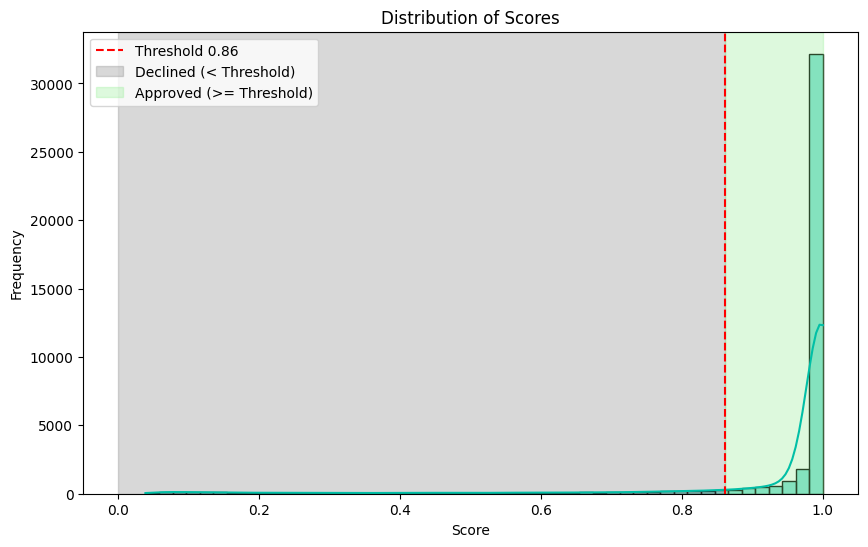

In [11]:
plt.figure(figsize=(10,6))
sns.histplot(df_['classification_score'], bins=50, kde=True, color='#01BFA6')

plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold {threshold:.2f}')

plt.axvspan(0, threshold, color='gray', alpha=0.3, label='Declined (< Threshold)')

plt.axvspan(threshold, 1, color='lightgreen', alpha=0.3, label='Approved (>= Threshold)')

plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()


## Task 3

In [12]:
# orders approved by the model with the threshold found
df_['model_decision'] = df_['classification_score'].apply(lambda x: 'approve' if x >= threshold else 'decline')

# only approved orders
approved_orders = df_[df_['model_decision'] == 'approve']

# total cost of approved chargebacks
chb_cost = approved_orders[approved_orders['order_status'] == 'chargeback']['price'].sum()

# potential revenue (fee * total price of approved orders)
total_approved_revenue = approved_orders['price'].sum()

# fee required for the cost of CHB to be 50% of revenue
fee_needed = chb_cost / (0.5 * total_approved_revenue)

print(f'Total cost of CHB in approved applications: {chb_cost:.2f}')
print(f'Total revenue from approved applications: {total_approved_revenue:.2f}')
print(f'Fee required for CHB cost to be 50% of revenue: {fee_needed:.4f} ({fee_needed*100:.2f}%)')


Total cost of CHB in approved applications: 15092.94
Total revenue from approved applications: 15411656.27
Fee required for CHB cost to be 50% of revenue: 0.0020 (0.20%)
